In [1]:
import os
os.chdir('C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto')

In [2]:
u=!pip freeze
instalados=str(u)

In [3]:
to_instalar=['os','pandas','matplotlib','statsmodels','numpy','seaborn','pingouin','pycaret','sklearn','scipy','openpyxl','optuna',
            'xgboost','sns']

In [4]:
instalados=[x for x in to_instalar if x in  instalados ]
if len(set(to_instalar)-set(instalados))>0:
    !pip install -r requirements_pycaret.txt 

In [5]:
import pycaret

In [6]:
import optuna

In [7]:
#!pip install -r requirements.txt --user
import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from datetime import datetime
import math
import unicodedata
from unicodedata import normalize
import re
from dateutil.relativedelta import relativedelta
import pingouin
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import scipy
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
#import tune_sklearn
#import pycaret

c:\users\usuario\documents\entornos_virtuales\entornoprueba\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [8]:
ruta_madre="C:/Users/USUARIO/Documents/GitHub/Team_224/Proyecto"
ruta_insumos=os.path.join(ruta_madre, 'Insumos')
ruta_resultados=os.path.join(ruta_madre, 'Resultados')

## 1.0 Importando base de datos preprocesada

In [55]:
os.chdir(os.path.join(ruta_insumos,'preproccess_data'))
ruta_data_preproc=os.path.join(os.getcwd(),'data_agregada_preproccess.xlsx')
datos_preproc=pd.read_excel(ruta_data_preproc,index_col=0)


## 2.0 Featuring engineering 

Es empiza a hacer Feature engineering para evitar resultados raros

### 2.1 Deflactando los salarios

Debido al gran problema que genera la inflación a lo largo del tiempo, se prefiere usar cifras deflactadas, con lo cual, se utiliza la tabal abstraida del DANE para el IPC anual y se indexa hasta valores correspondientes al 2022. Es decir, la serie se deflacta y se pone todo en las mismas unidades monetarias en el mismo intervalo de tiempo

In [56]:
inflacion_variacion=pd.read_excel(os.path.join(os.getcwd(),'inflacion.xlsx'),index_col=0)
inflacion_variacion['inflacion']=inflacion_variacion['inflacion']/100+1
inflacion_variacion=inflacion_variacion[inflacion_variacion.index>=datos_preproc.year.min()]

In [57]:
inflacion_variacion=inflacion_variacion.sort_index(ascending=False).cumprod().reset_index()

In [58]:
datos_preproc=datos_preproc.merge(inflacion_variacion,on="year",how="left")
datos_preproc.inflacion.fillna(1,inplace=True)

In [59]:
datos_preproc['wage_deflacted']=datos_preproc['wage_imputed']*datos_preproc['inflacion']

### 2.2 Arreglando variables categoricas incompletas

In [60]:
datos_preproc['total_depedants']=datos_preproc['other_on_charge_person']+datos_preproc['children_amount']

In [61]:
datos_to_model=datos_preproc[['month','gender','is_special_population','any_disability','MUNICIPIO_DE_RESIDENCIA','home_type',
                             'education_level','PROFESION','marital_status','total_depedants','ESTRATO_SOCIAL','wage_deflacted',
                             'age','years_exp_current_role','request_attend_per_day']].copy()
datos_to_model['total_depedants']=datos_to_model['total_depedants'].astype('str')
datos_to_model['ESTRATO_SOCIAL']=datos_to_model['ESTRATO_SOCIAL'].astype('str')

In [62]:
datos_to_model.isna().sum()

month                       0
gender                      3
is_special_population       3
any_disability              3
MUNICIPIO_DE_RESIDENCIA     3
home_type                   3
education_level             3
PROFESION                  65
marital_status              3
total_depedants             0
ESTRATO_SOCIAL              0
wage_deflacted              0
age                         3
years_exp_current_role      3
request_attend_per_day      0
dtype: int64

Note que hay un total importante de NAs en algunos datos. sin embargo, no tenemos ninguna explicación de negocio para reemplazarlos por un numero, por lo que se pondrá como una nueva categoria

In [63]:
datos_to_model['gender']=datos_to_model['gender'].fillna('OTHER')
datos_to_model['is_special_population']=datos_to_model['is_special_population'].fillna('NO APLICA')
datos_to_model['any_disability']=datos_to_model['any_disability'].fillna('no_reported')
datos_to_model['MUNICIPIO_DE_RESIDENCIA']=datos_to_model['MUNICIPIO_DE_RESIDENCIA'].fillna('NO_REPORTADO')
datos_to_model['home_type']=datos_to_model['home_type'].fillna('OTHER')
datos_to_model['education_level']=datos_to_model['education_level'].fillna('OTHER')
datos_to_model['PROFESION']=datos_to_model['PROFESION'].fillna('OTHER')
datos_to_model['marital_status']=datos_to_model['marital_status'].fillna('OTHER')
datos_to_model['total_depedants']=datos_to_model['total_depedants'].fillna('OTHER')
datos_to_model['ESTRATO_SOCIAL']=datos_to_model['ESTRATO_SOCIAL'].fillna('OTHER')

El siguiente codigo presenta una transformacion de la variable edad, ya que al verlo respecto a la variable que mide la productividad, tiene una relacion no lineal. 

### 2.3 Agregadno polinomios de la edad

In [64]:
datos_to_model['age2']=datos_to_model['age']**2
datos_to_model['age3']=datos_to_model['age']**3
datos_to_model['age4']=datos_to_model['age']**4
datos_to_model['age5']=datos_to_model['age']**5

### 2.1 Regresion lineal sin ninguna modificacion

#### 2.1.1 Dividiendo en test y train set

Utilzamos un split de 70/30, sin embargo, solo usaremos este ejercicio con fin de tener una referencia de potenciales variables significativas. siendo el peor modelo y luego ir viendo como se comporta a futuro

In [65]:
y=datos_to_model[datos_to_model.columns[datos_to_model.columns=='request_attend_per_day']].copy()
X=datos_to_model[datos_to_model.columns[datos_to_model.columns!='request_attend_per_day']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [66]:
y_train

,request_attend_per_day
98,20.233333
697,66.322581
1536,66.354839
638,61.709677
1176,50.200000
...,...
715,0.548387
905,22.580645
1096,8.500000
235,3.366667


#### 2.1.2 Normalizando y transformando las variables

Normalizaremos salario y años de experiencia y todas las variables de edad

In [67]:
scaler = StandardScaler()

stand_xtrain=scaler.fit_transform(X_train[['wage_deflacted','years_exp_current_role','age','age2','age3','age4','age5']])
X_train[['wage_deflacted','years_exp_current_role','age','age2','age3','age4','age5']]=pd.DataFrame(stand_xtrain,columns=['wage_imputed','years_exp_current_role','age','age2','age3','age4','age5'],
                                                                                                 index=X_train.index)

stand_xtest=scaler.fit_transform(X_test[['wage_deflacted','years_exp_current_role','age','age2','age3','age4','age5']])
X_test[['wage_deflacted','years_exp_current_role','age','age2','age3','age4','age5']]=pd.DataFrame(stand_xtest,columns=['wage_imputed','years_exp_current_role','age','age2','age3','age4','age5'],
                                                                                                index=X_test.index)


#### 2.1.3 Aplicando un box cox a ver si se puede transformar

Se aplica una vez ya se crea el train set y el test set

In [68]:
from scipy import stats
ytrain_transformed, box_cox_lambda_ytrain = stats.boxcox(y_train.request_attend_per_day)
ytest_transformed, box_cox_lambda_ytest = stats.boxcox(y_test.request_attend_per_day)

Text(0.5, 1.0, 'Response variable test Original')

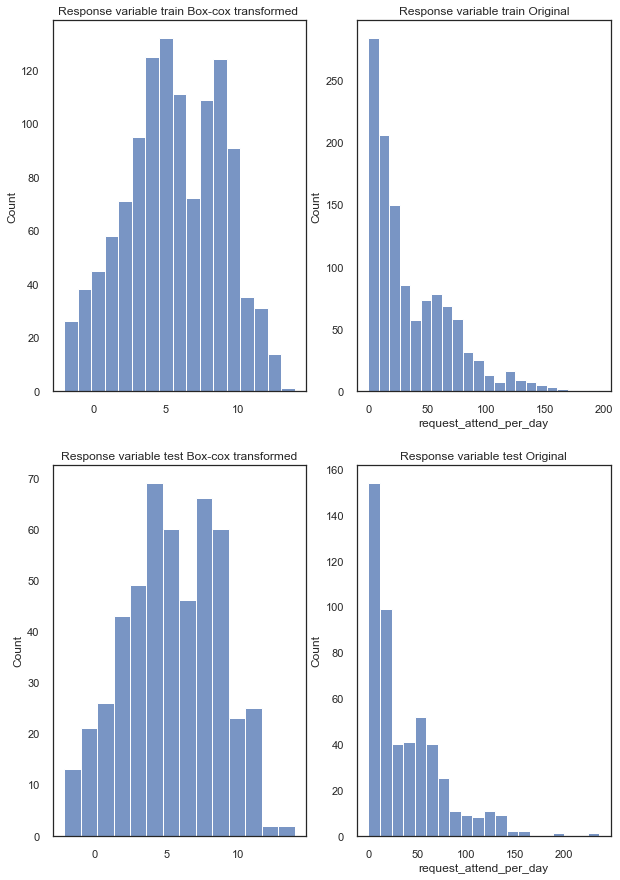

In [69]:
sns.set_theme()
sns.set_style('white')
plt.figure(figsize=(10,15))

plt.subplot(2,2,1)
sns.histplot(ytrain_transformed)
plt.title('Response variable train Box-cox transformed ')

plt.subplot(2,2,2)
sns.histplot(y_train.request_attend_per_day)
plt.title('Response variable train Original')

plt.subplot(2,2,3)
sns.histplot(ytest_transformed)
plt.title('Response variable test Box-cox transformed')

plt.subplot(2,2,4)
sns.histplot(y_test.request_attend_per_day)
plt.title('Response variable test Original')

Si es útil hacer la transformacion de box cox, ya que le disminuye el sesgo. por lo cual, deberíamos aplicarla.

In [70]:
#X_train_extended = sm.add_constant(X_train)
X_train_extended = X_train.copy()
X_train_extended['month']=X_train_extended.month.astype('category')
X_train_extended['gender']=X_train_extended.gender.astype('category')
X_train_extended['is_special_population']=X_train_extended.is_special_population.astype('category')
X_train_extended['any_disability']=X_train_extended.any_disability.astype('category')
X_train_extended['MUNICIPIO_DE_RESIDENCIA']=X_train_extended.MUNICIPIO_DE_RESIDENCIA.astype('category')
X_train_extended['home_type']=X_train_extended.home_type.astype('category')
X_train_extended['PROFESION']=X_train_extended.PROFESION.astype('category')
X_train_extended['marital_status']=X_train_extended.marital_status.astype('category')
X_train_extended['total_depedants']=X_train_extended.total_depedants.astype('category')
X_train_extended['ESTRATO_SOCIAL']=X_train_extended.ESTRATO_SOCIAL.astype('category')
X_train_extended['education_level']=X_train_extended.education_level.astype('category')

In [71]:
X_train_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 98 to 1061
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   month                    1178 non-null   category
 1   gender                   1178 non-null   category
 2   is_special_population    1178 non-null   category
 3   any_disability           1178 non-null   category
 4   MUNICIPIO_DE_RESIDENCIA  1178 non-null   category
 5   home_type                1178 non-null   category
 6   education_level          1178 non-null   category
 7   PROFESION                1178 non-null   category
 8   marital_status           1178 non-null   category
 9   total_depedants          1178 non-null   category
 10  ESTRATO_SOCIAL           1178 non-null   category
 11  wage_deflacted           1178 non-null   float64 
 12  age                      1176 non-null   float64 
 13  years_exp_current_role   1176 non-null   float64 
 14  age2   

In [72]:
data_train=X_train_extended.copy()
data_train['request_per_day']=ytrain_transformed

In [73]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 98 to 1061
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   month                    1178 non-null   category
 1   gender                   1178 non-null   category
 2   is_special_population    1178 non-null   category
 3   any_disability           1178 non-null   category
 4   MUNICIPIO_DE_RESIDENCIA  1178 non-null   category
 5   home_type                1178 non-null   category
 6   education_level          1178 non-null   category
 7   PROFESION                1178 non-null   category
 8   marital_status           1178 non-null   category
 9   total_depedants          1178 non-null   category
 10  ESTRATO_SOCIAL           1178 non-null   category
 11  wage_deflacted           1178 non-null   float64 
 12  age                      1176 non-null   float64 
 13  years_exp_current_role   1176 non-null   float64 
 14  age2   

In [74]:
formula='request_per_day~'
for i in range(len(data_train.columns)):
    if i ==0 and data_train.columns[i]!='request_per_day':
        formula= formula + data_train.columns[i]
    elif data_train.columns[i]!='request_per_day' and i !=0:
        formula= formula+'+'+ data_train.columns[i]
    else:
        continue
    
    

In [75]:
linear_model_baseline=smf.ols(formula=formula,data=data_train).fit() 

In [76]:
linear_model_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        request_per_day   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     30.28
Date:                Thu, 30 Jun 2022   Prob (F-statistic):          1.68e-178
Time:                        21:58:54   Log-Likelihood:                -2565.6
No. Observations:                1176   AIC:                             5239.
Df Residuals:                    1122   BIC:                             5513.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================
                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              -12.6834      1.220    -10.394      0.000     -15.078     -10.289
month[T.2]                                                                                               0.7102      0.310      2.291      0.022       0.102       1.319
month[T.3]                                                                                               0.2803      0.302      0.927      0.354      -0.313       0.874
month[T.4]                                                                                              -0.2472      0.300     -0.825      0.409      -0.835       0.341
month[T.5]                                                                                              -0.3098      0.333     -0.931      0.352      -0.962       0.343
month[T.6]                                                                                              -0.2586      0.324     -0.799      0.424      -0.893       0.376
month[T.7]                                                                                               0.1365      0.332      0.411      0.681      -0.514       0.787
month[T.8]                                                                                               0.2582      0.325      0.795      0.427      -0.379       0.895
month[T.9]                                                                                               0.2217      0.323      0.687      0.492      -0.411       0.855
month[T.10]                                                                                              0.5071      0.322      1.577      0.115      -0.124       1.138
month[T.11]                                                                                              0.3292      0.327      1.008      0.314      -0.312       0.970
month[T.12]                                                                                             -0.6246      0.313     -1.994      0.046      -1.239      -0.010
gender[T.MALE]                                                                                           1.2026      0.650      1.851      0.064      -0.072       2.478
gender[T.OTHER]                                                                                       1.904e-11   4.59e-12      4.146      0.000       1e-11    2.81e-11
is_special_population[T.MADRE CABEZA DE FAMILIA]                                                        10.2007      2.161      4.720      0.000       5.960      14.441
is_special_population[T.MUJER GESTANTE]  

In [77]:
linear_model_baseline.pvalues.index[np.where(linear_model_baseline.pvalues<0.05/len(linear_model_baseline.pvalues))].to_frame().reset_index(drop=True)

,0
0,Intercept
1,gender[T.OTHER]
2,is_special_population[T.MADRE CABEZA DE FAMILIA]
3,is_special_population[T.MUJER GESTANTE]
4,is_special_population[T.NO APLICA]
5,is_special_population[T.VICTIVA CONFLICTO ARMADO]
6,any_disability[T.no_reported]
7,MUNICIPIO_DE_RESIDENCIA[T.cerete]
8,MUNICIPIO_DE_RESIDENCIA[T.cienaga_de_oro]
9,MUNICIPIO_DE_RESIDENCIA[T.montelibano]


In [78]:
linear_model_baseline.fvalue ### valor del ANOVA agregado del modelo.

30.284164250120487

In [79]:
anova_test=sm.stats.anova_lm(linear_model_baseline,typ=1)

In [80]:
print(anova_test)

                             df       sum_sq     mean_sq          F  \
month                      11.0   109.912503    9.992046   2.073973   
gender                      2.0    80.933915   40.466957   8.399420   
is_special_population       4.0   298.118199   74.529550  15.469534   
any_disability              1.0     7.951165    7.951165   1.650363   
MUNICIPIO_DE_RESIDENCIA     8.0  1251.293454  156.411682  32.465188   
home_type                   3.0   107.298132   35.766044   7.423687   
education_level             3.0   251.487231   83.829077  17.399767   
PROFESION                  10.0  3104.604514  310.460451  64.439924   
marital_status              4.0   430.256908  107.564227  22.326292   
total_depedants             7.0  1104.495755  157.785108  32.750260   
ESTRATO_SOCIAL              3.0   356.987046  118.995682  24.699032   
wage_deflacted              1.0    15.945694   15.945694   3.309727   
age                         1.0     8.515106    8.515106   1.767416   
years_

In [81]:
#model_region_no_oldest_box_cox=smf.ols(
 #   formula='Cost_BC_transformed~Region+group_size+homeowner+car_age+car_value+age_youngest+married_couple+C_previous+duration_previous+A+E+F+G',
  #  data=train_expanded).fit()

En la regresion arriba mencionada, se puede observar que el R squared se acerca al 58% de explicación, que no es malo, pero definitivamente no es el mejor, del mismo modo, haciendo pruebas de hipotesis individuales aplicando la coreccion de bonferroni, se observa que las únicas variables que individualmente se eliminan por baja significancia estadistica es la variable categoria 'month' y el 'wage_deflacted'. este último puede estar atado al hecho de que el cargo es estandar y de baja calificación profesional, que la diferencia de salarios entre ellos no es significativa. De igual manera, note que al tener una variable dependiente continua y casi normal, es posible ver el análsiis ANOVA, la cual muestra que en general, alguna o varias de los betas son diferentes de cero.


Dado lo anterior, se puede observar que con las variables significativas se puede volver a correr un modelo de la siguiente forma:

In [82]:
formula2='request_per_day~gender+is_special_population+any_disability+MUNICIPIO_DE_RESIDENCIA+home_type+education_level+PROFESION+marital_status+total_depedants+ESTRATO_SOCIAL+age+years_exp_current_role+age2+age3+age4+age5'

In [83]:
data_train.education_level.unique()

['PROFESIONAL', 'TECNICO', 'TECNOLOGO', 'OTHER']
Categories (4, object): ['OTHER', 'PROFESIONAL', 'TECNICO', 'TECNOLOGO']

In [84]:
linear_model_baseline_mod=smf.ols(formula=formula2,data=data_train).fit() 
linear_model_baseline_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        request_per_day   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     37.06
Date:                Thu, 30 Jun 2022   Prob (F-statistic):          1.19e-178
Time:                        21:58:59   Log-Likelihood:                -2587.9
No. Observations:                1176   AIC:                             5260.
Df Residuals:                    1134   BIC:                             5473.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================
                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              -12.0141      1.210     -9.931      0.000     -14.388      -9.640
gender[T.MALE]                                                                                           1.1100      0.658      1.687      0.092      -0.181       2.401
gender[T.OTHER]                                                                                       9.989e-12   2.23e-12      4.485      0.000    5.62e-12    1.44e-11
is_special_population[T.MADRE CABEZA DE FAMILIA]                                                        10.1129      2.185      4.627      0.000       5.825      14.401
is_special_population[T.MUJER GESTANTE]                                                                 17.7599      4.258      4.171      0.000       9.406      26.114
is_special_population[T.NO APLICA]                                                                      15.5141      1.787      8.684      0.000      12.009      19.020
is_special_population[T.VICTIVA CONFLICTO ARMADO]                                                       26.0912      2.262     11.536      0.000      21.654      30.529
any_disability[T.no_reported]                                                                        -1.233e-11   2.84e-12     -4.341      0.000   -1.79e-11   -6.76e-12
MUNICIPIO_DE_RESIDENCIA[T.cerete]                                                                       17.7599      4.258      4.171      0.000       9.406      26.114
MUNICIPIO_DE_RESIDENCIA[T.cienaga_de_oro]                                                               -8.3003      1.097     -7.568      0.000     -10.452      -6.148
MUNICIPIO_DE_RESIDENCIA[T.montelibano]                                                                  10.0164      1.683      5.950      0.000       6.713      13.319
MUNICIPIO_DE_RESIDENCIA[T.monteria]                                                                     -9.5507      1.080     -8.842      0.000     -11.670      -7.431
MUNICIPIO_DE_RESIDENCIA[T.murindo]                                                                       0.5237      1.168      0.448      0.654      -1.769       2.816
MUNICIPIO_DE_RESIDENCIA[T.planeta_rica]                                                                 -9.7998      1.167     -8.401      0.000     -12.089      -7.511
MUNICIPIO_DE_RESIDENCIA[T.sahagun]                                                                     -14.8692      1.217    -12.219      0.000     -17.257     -12.482
MUNICIPIO_DE_RESIDENCIA[T.san_pelayo]    

Dado el anterior modelo, podemos encontrar un perfl potencial base que nos dice que: la mayor productividad puede ser de un perfil que sea hombre, que no tenga ninguna condicion especial (o provenga del conflicto armado) que provenga de cerete, que viva en casa familiar, con un nivel profesional por fuera de los tradicionales y que tenga profesiones relacionadas a secretariado y/o asistete administrativo, donde como maximo tenga 3 dependientes (probablemente 8 de significativamente grande por temas a pocos datos, con estrato social 3 y con mayor años de experiencia. la edad es un factor positivamente fundamental para la productividad, pero va disminuyendo marginalmente a medida que aumenta.

Debido a que este modelo es de referencia, decidimos no hacer ninguna prueba de supuestos por el momento.

## 3.0 Encontrando el modelo adecuado

Es empiza a hacer las investigaciones avanzadas para determinar cual es el mejor modelo

### 3.1 Modelo de regresión

Iniciamos con modelos de regresión a través de pycaret

In [85]:
datos_to_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 0 to 1682
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   month                    1683 non-null   int64  
 1   gender                   1683 non-null   object 
 2   is_special_population    1683 non-null   object 
 3   any_disability           1683 non-null   object 
 4   MUNICIPIO_DE_RESIDENCIA  1683 non-null   object 
 5   home_type                1683 non-null   object 
 6   education_level          1683 non-null   object 
 7   PROFESION                1683 non-null   object 
 8   marital_status           1683 non-null   object 
 9   total_depedants          1683 non-null   object 
 10  ESTRATO_SOCIAL           1683 non-null   object 
 11  wage_deflacted           1683 non-null   float64
 12  age                      1680 non-null   float64
 13  years_exp_current_role   1680 non-null   float64
 14  request_attend_per_day  

### 3.1.1 Setting up the parameters

Notará que la siguiente linea permite que pycaret haga gran parte pornosotros, primero le relacionamos las variables que serán categóricas y permitimos que:
1) se estandarice (mediante z score) las variables numéricas
2) ignorará las variables que posean 0 varianza aproximadamente
3) permitirá crear una gama e variables más grande, a través de combinaciones de todas las variables. 
4) elimina una de las variables, de aquel par que poseauna correlación de 85% o más
5) como se vio anteriormente, la transformación de la variable respuesta puede ser útil, por lo que permitimos hacer la transformación de Box-cox
6) Se implementa una combinación de Random_forest y regresiones lineales para escoger solo las variables más representativas.

In [86]:
datos_to_model=datos_to_model.drop(columns='month')


In [89]:
datos_to_model.to_excel(os.path.join(ruta_insumos,'master_data','data_master_ready_to_model.xlsx'))

In [107]:
from pycaret.regression import *
set_model = setup(datos_to_model, target = 'request_attend_per_day',categorical_features=['gender','is_special_population','any_disability','MUNICIPIO_DE_RESIDENCIA','home_type','education_level',
                                                                                  'marital_status','PROFESION','total_depedants','ESTRATO_SOCIAL'],
          normalize=True,normalize_method='zscore',feature_interaction=True,ignore_low_variance=True,transform_target=True,transform_target_method='box-cox',
          feature_selection=True,feature_selection_threshold=0.85,remove_multicollinearity=True,multicollinearity_threshold=0.85,session_id=1229,train_size=0.70,fold_strategy='kfold',
                 fold=10)

,Description,Value
0,session_id,1229
1,Target,request_attend_per_day
2,Original Data,"(1683, 18)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1178, 68)"


Para este caso, corremos el modelo y seleccionamos el mejor de acuerdo al que tenga el mínimo RMSE. para ello, se obseerva que el Random Forest para regresión es el menor, mejorando en promedio en casi 4 unidades el modelo de regresión lineal y casi aumentando en 20 puntos porcnentales su R2.

In [108]:
best=compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,9.6400,259.9508,15.8831,0.7725,0.5635,1.7544,0.0810
rf,Random Forest Regressor,9.7729,269.6187,16.2499,0.7664,0.5610,2.1306,0.1040
catboost,CatBoost Regressor,10.2280,268.3798,16.2690,0.7667,0.5781,2.7618,0.8450
xgboost,Extreme Gradient Boosting,10.2554,274.0927,16.4468,0.7564,0.5870,2.8353,0.0710
lightgbm,Light Gradient Boosting Machine,10.6493,290.9208,16.9436,0.7475,0.5914,2.7105,0.0350
dt,Decision Tree Regressor,10.9673,346.3969,18.3564,0.6933,0.6509,2.6450,0.1840
knn,K Neighbors Regressor,11.7489,368.0642,19.0301,0.6807,0.6755,2.8128,0.3640
gbr,Gradient Boosting Regressor,13.1517,431.1028,20.6304,0.6294,0.6898,3.3675,0.0450
lr,Linear Regression,15.3345,585.6130,23.8788,0.4912,0.7616,2.5099,0.3400
br,Bayesian Ridge,15.7227,585.3457,23.9736,0.4947,0.7772,3.3259,0.0090


In [109]:
print(best)

PowerTransformedTargetRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                powe...
                                regressor=ExtraTreesRegressor(bootstrap=False,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                             

In [110]:
modelo_seleccionado=create_model(best,criterion='mse') ##

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.5736,206.3006,14.3632,0.8028,0.5961,0.9592
1,11.7540,463.8497,21.5372,0.6320,0.6542,1.1913
2,8.7654,193.0850,13.8955,0.8537,0.4904,1.0470
3,11.5392,337.7702,18.3785,0.6391,0.6684,2.0327
4,9.5440,236.5244,15.3793,0.8200,0.4159,0.6460
5,10.1004,264.5600,16.2653,0.7480,0.6337,1.6586
6,9.5738,256.8007,16.0250,0.8098,0.5094,2.7574
7,6.7413,108.7299,10.4274,0.8813,0.5290,5.3612
8,10.9034,297.0418,17.2349,0.7932,0.5479,0.5198


In [111]:
RMSE_best_model_notuned=pull()

In [112]:
RMSE_notuned=RMSE_best_model_notuned.loc['Mean'].RMSE

A pesar que random Forest parece ser el más útil para este caso, tendríamos un problema y sería al establecer todos los hiperparámetros que requiere este método. Para este caso, se utiliza el proceso de 'tuning' que trata de optimizar el RMSE de acuerdo al conjunto de hiperparámetros que seerán escogidos a través de optimización bayesiana.

### 3.1.2 Tuneando el modelo


Acá se planea optimizar los hiperparámetros del modelo elegido para ver si es posible mejorar su rendimiento


In [113]:
#pip install tune-sklearn ray[tune]* 
#modelo_tuneado=tune_model(modelo_seleccionado, search_library = 'tune-sklearn', search_algorithm = 'hyperopt',choose_better=True,optimize='RMSE',n_iter=30)

modelo_tuneado=tune_model(modelo_seleccionado, search_library = 'optuna',choose_better=True,optimize='RMSE',n_iter=30)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.9834,337.6025,18.3740,0.6772,0.6242,1.1944
1,12.7597,444.5652,21.0847,0.6473,0.7190,1.9107
2,12.2170,446.4178,21.1286,0.6617,0.6419,1.8772
3,12.8016,341.8556,18.4893,0.6347,0.7853,2.6251
4,12.7401,362.4015,19.0368,0.7242,0.5803,1.0015
5,11.0255,284.5875,16.8697,0.7289,0.6659,1.8401
6,12.0948,400.1095,20.0027,0.7036,0.6120,2.9822
7,10.7025,289.4361,17.0128,0.6841,0.6583,9.6661
8,14.9775,653.2136,25.5580,0.5453,0.5962,0.9573


In [114]:
print(modelo_seleccionado)

PowerTransformedTargetRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                powe...
                                regressor=ExtraTreesRegressor(bootstrap=False,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                             

In [115]:
print(modelo_tuneado)

PowerTransformedTargetRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                powe...
                                regressor=ExtraTreesRegressor(bootstrap=False,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                             

In [116]:
modelo_seleccionado_tuneado=create_model(modelo_tuneado,criterion='mse')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.5736,206.3006,14.3632,0.8028,0.5961,0.9592
1,11.7540,463.8497,21.5372,0.6320,0.6542,1.1913
2,8.7654,193.0850,13.8955,0.8537,0.4904,1.0470
3,11.5392,337.7702,18.3785,0.6391,0.6684,2.0327
4,9.5440,236.5244,15.3793,0.8200,0.4159,0.6460
5,10.1004,264.5600,16.2653,0.7480,0.6337,1.6586
6,9.5738,256.8007,16.0250,0.8098,0.5094,2.7574
7,6.7413,108.7299,10.4274,0.8813,0.5290,5.3612
8,10.9034,297.0418,17.2349,0.7932,0.5479,0.5198


In [117]:
model_tuned_results = pull()

In [118]:
model_selected_tuned=model_tuned_results.loc['Mean'].RMSE

Se saca el modelo tuneado y e compara con el normal. y se escoge el que más bajo RMSE tenga

In [119]:
if model_selected_tuned>RMSE_notuned:
    final_model=model_selected_tuned
else:
    final_model=modelo_seleccionado

La siguiente linea corre el modelo escogido por el algoritmo

In [91]:
os.chdir('C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto\\Codigo\\Modelling')
all_data_final_model=finalize_model(final_model)
save_model(all_data_final_model, 'C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto\\Models\\model_selected_pipeline')


In [120]:
save_config('C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto\\Models\\model_selected_config')


In [123]:
import joblib
joblib.dump(final_model,'C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto\\Models\\final_model_visualization.data')

['C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto\\Models\\final_model_visualization.data']

### 4 Predicción del modelo

Una vez se escoge el modelo, lo que se sugiere hacer es utilizar el modelo sobre toda la data, y en el request front end, se relacione las variables `gender`,`is_special_population`,`any_disability`,`MUNICIPIO_DE_RESIDENCIA`,`home_type`, `education_level`,`PROFESION`,`marital_status`,`total_depedants`,`ESTRATO_SOCIAL`, `age`, `years_exp_current_role`. Donde el sueldo será puesto internamente por  la entidad de salud y las varables polinómicas de la edad, serán calculadaas ua vez se calcule la edad.	 Para las variables `age`, `years_exp_current_role` son numéricas y `ESTRATO_SOCIAL`, `total_depedants` parecen numericas pero tambien son categoricas ordinales. así que ojo!

**Pronostico de prueba**

In [47]:
#os.chdir('C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto\\Codigo\\Modelling')
all_data_final_model=load_model('C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto\\Models\\model_selected_pipeline')


Transformation Pipeline and Model Successfully Loaded


In [52]:
all_data_final_model

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['gender',
                                                            'is_special_population',
                                                            'any_disability',
                                                            'MUNICIPIO_DE_RESIDENCIA',
                                                            'home_type',
                                                            'education_level',
                                                            'marital_status',
                                                            'PROFESION',
                                                            'total_depedants',
                                                            'ESTRATO_SOCIAL'],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
              

In [102]:
##load_model('model_selected_pipeline')## para cargar de vuelta el modelo
age=50
gender='FEMALE'
is_special_population='NO APLICA'
municipio_living='monteria'
home_type='ARRENDADA'
education_level='PROFESIONAL'
PROFESION='admin_empresas'
marital_status='SINGLE'
total_dependants='1.0'
ESTRATO_SOCIAL='1.0'
years_exp_current_role=10

In [103]:
new_data=datos_to_model.iloc[[0,]].copy()
new_data=new_data.drop(columns='request_attend_per_day')
new_data['age']=float(age)
new_data['age2']=float(age)**2
new_data['age3']=float(age)**3
new_data['age4']=float(age)**4
new_data['age5']=float(age)**5
new_data['is_special_population']=is_special_population
new_data['municipio_living']=municipio_living
new_data['home_type']=home_type
new_data['education_level']=education_level
new_data['marital_status']=marital_status
new_data['total_dependants']=str(total_dependants)
new_data['ESTRATO_SOCIAL']=str(ESTRATO_SOCIAL)
new_data['years_exp_current_role']=float(years_exp_current_role)
new_data['PROFESION']=PROFESION

In [104]:
predicted_value=predict_model(all_data_final_model, data = new_data)

In [105]:
predicted_value.Label ### este es los requerimientos atendidos por dia que tendrá esa persona

0    19.137028
Name: Label, dtype: float64

In [52]:
unicos={}
for i in datos_to_model.select_dtypes('object' or 'category').columns.to_list():
    unicos[i]=datos_to_model[i].unique()


In [70]:
import joblib
joblib.dump(unicos,'unicos_categorias.data')

['unicos_categorias.data']

In [71]:
os.getcwd()

'C:\\Users\\USUARIO\\Documents\\GitHub\\Team_224\\Proyecto\\Codigo\\Modelling'

### 4.1 Determinar si se coontrata un empleado o no

La idea es transformar los requerimientos por dia de toda la data en box.cox, luego tomar el cuantil 75 y ese valor volver a transformarlo para saber si se contrata o no

In [54]:
y_transformada, box_cox_lambda_y = stats.boxcox(datos_to_model.request_attend_per_day)

In [55]:
prob_75=np.quantile(y_transformada,0.75)
prob_50=np.quantile(y_transformada,0.5)
prob_90=np.quantile(y_transformada,0.90)

In [56]:
valores_quantiles=scipy.special.inv_boxcox(np.asarray([prob_50,prob_75,prob_90]), box_cox_lambda_y)

In [57]:
valores_quantiles

array([23.26666667, 56.53225649, 81.5       ])

In [46]:
#if predicted_value.Label>valores_quantiles[2] :
#    print('Excelente perfil. contrátalo')
#elif (predicted_value.Label>valores_quantiles[1] and predicted_value.Label<=valores_quantiles[2]):
#    print('Es un perfil sobresaliente. contrátalo')
#elif (predicted_value.Label>valores_quantiles[0] and predicted_value.Label<=valores_quantiles[1]):
#    print('Es un perfil estandar. podrías con periodo de prueba')
#else:
#    print('No es tan productivo. ten cuidado')

In [54]:
import session_info

In [57]:
session_info.show(html=False)

-----
dateutil            2.8.2
matplotlib          3.5.2
numpy               1.19.5
pandas              1.3.5
pingouin            0.3.12
pycaret             2.3.10
scipy               1.5.4
seaborn             0.11.2
session_info        1.0.0
sklearn             0.23.2
statsmodels         0.13.2
-----
IPython             7.34.0
jupyter_client      7.3.4
jupyter_core        4.10.0
notebook            6.4.12
-----
Python 3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]
Windows-10-10.0.19041-SP0
-----
Session information updated at 2022-06-28 20:21


In [121]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [19]:
from pycaret.datasets import get_data
data = get_data('insurance')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [21]:
from pycaret.regression import *
s = setup(data, target = 'charges')

,Description,Value
0,session_id,3750
1,Target,charges
2,Original Data,"(1338, 7)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(936, 14)"


In [22]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2485.4792,21393519.7702,4545.0700,0.8446,0.3882,0.2647,0.0110
rf,Random Forest Regressor,2610.6134,22739090.1617,4687.6105,0.8343,0.3871,0.2645,0.0870
lightgbm,Light Gradient Boosting Machine,2835.9005,23961066.8710,4829.2867,0.8256,0.4968,0.3198,0.0110
ada,AdaBoost Regressor,3750.8889,25505086.0503,5013.0329,0.8174,0.5358,0.5475,0.0070
et,Extra Trees Regressor,2610.8542,26527500.9759,5072.4048,0.8060,0.4002,0.2519,0.0800
ridge,Ridge Regression,4228.5423,38645870.6000,6178.6240,0.7264,0.5634,0.4111,0.0050
llar,Lasso Least Angle Regression,4213.0760,38624375.1366,6176.9871,0.7264,0.5658,0.4094,0.0050
br,Bayesian Ridge,4225.7514,38650611.9634,6178.9181,0.7263,0.5645,0.4106,0.0050
lasso,Lasso Regression,4215.4111,38648265.0000,6178.5144,0.7261,0.5720,0.4087,0.1520
lr,Linear Regression,4215.0066,38649401.2000,6178.5908,0.7261,0.5741,0.4085,0.2880


In [23]:
print(best)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=3750, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [31]:
evaluate_model(best)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [32]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


# BORRAR ESTO

In [3]:
from pycaret.datasets import get_data
employee = get_data('employee')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


In [6]:
employee.salary.unique()

array(['low', 'medium', 'high'], dtype=object)

In [10]:
# load dataset
from pycaret.datasets import get_data
income = get_data('income')

# init setup
from pycaret.classification import *
clf1 = setup(data = income, target = 'income >50K', high_cardinality_features = ['native-country'],high_cardinality_method="clustering")

,Description,Value
0,session_id,1836
1,Target,income >50K
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(32561, 14)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,True


In [19]:
# load dataset
from pycaret.datasets import get_data
pokemon = get_data('pokemon')

# init setup
from pycaret.classification import *
clf1 = setup(data = pokemon, target = 'Total', normalize = True)

,Description,Value
0,session_id,4949
1,Target,Total
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(800, 13)"
5,Missing Values,True
6,Numeric Features,7
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
# load dataset
from pycaret.datasets import get_data 
boston = get_data('boston') 

# init setup
from pycaret.regression import * 
reg1 = setup(boston, target = 'medv')

# train model
dt = create_model('dt')

# tune model sklearn
#tune_model(dt)

# tune model optuna
#tune_model(dt, search_library = 'optuna')

# tune model scikit-optimize
#tune_model(dt, search_library = 'scikit-optimize',search_algorithm='bayesian')
tune_model(dt, search_library = 'scikit-learn',search_algorithm='GridSearchCV')
# tune model tune-sklearn
#tune_model(dt, search_library = 'tune-sklearn', search_algorithm = 'hyperopt')



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.8750,37.5697,6.1294,0.6380,0.1991,0.1440
1,2.4722,10.8372,3.2920,0.8780,0.2057,0.1478
2,3.7028,28.4031,5.3295,0.6662,0.1901,0.1557
3,3.0639,13.7647,3.7101,0.7777,0.2010,0.1764
4,2.8829,15.2580,3.9061,0.7502,0.1744,0.1315
5,3.2343,17.3297,4.1629,0.3191,0.2286,0.1833
6,3.0000,15.6377,3.9545,0.8356,0.1998,0.1543
7,3.0686,15.5240,3.9401,0.8674,0.1993,0.1475
8,2.8057,12.4103,3.5228,0.8011,0.1713,0.1511


ValueError: For 'scikit-learn' search_algorithm parameter must be one of random, grid

In [92]:
# load dataset
from pycaret.datasets import get_data
diabetes = get_data('diabetes')

# init setup
from pycaret.classification import *
clf1 = setup(data = diabetes, target = 'Class variable')

# create a model
xgboost = create_model('xgboost')

# predict on new data
predict_model(xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8148,0.8338,0.7500,0.7500,0.7500,0.6029,0.6029
1,0.8519,0.9103,0.9000,0.7500,0.8182,0.6949,0.7031
2,0.7407,0.8235,0.7500,0.6250,0.6818,0.4661,0.4716
3,0.6481,0.7485,0.5000,0.5263,0.5128,0.2377,0.2379
4,0.7778,0.7735,0.8000,0.6667,0.7273,0.5424,0.5488
5,0.7222,0.7971,0.5000,0.6667,0.5714,0.3721,0.3805
6,0.6852,0.7647,0.6000,0.5714,0.5854,0.3319,0.3321
7,0.6226,0.6318,0.4500,0.5000,0.4737,0.1808,0.1814
8,0.7547,0.7985,0.6500,0.6842,0.6667,0.4728,0.4732


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7186,0.7839,0.6232,0.5244,0.5695,0.3628,0.3658


,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Number of times pregnant_0,Number of times pregnant_1,Number of times pregnant_10,...,Number of times pregnant_3,Number of times pregnant_4,Number of times pregnant_5,Number of times pregnant_6,Number of times pregnant_7,Number of times pregnant_8,Number of times pregnant_9,Class variable,Label,Score
0,164.0,78.0,0.0,0.0,32.799999,0.148,45.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.8154
1,122.0,76.0,27.0,200.0,35.900002,0.483,26.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9961
2,109.0,76.0,39.0,114.0,27.900000,0.640,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0.7752
3,108.0,60.0,46.0,178.0,35.500000,0.415,24.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9879
4,125.0,96.0,0.0,0.0,22.500000,0.262,21.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,123.0,74.0,40.0,77.0,34.099998,0.269,28.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.9815
227,92.0,62.0,28.0,0.0,31.600000,0.130,24.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9937
228,121.0,66.0,30.0,165.0,34.299999,0.203,33.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9528
229,91.0,82.0,0.0,0.0,35.599998,0.587,68.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.9948


In [82]:
# load dataset
from pycaret.datasets import get_data
diabetes = get_data('diabetes')

# init setup
from pycaret.classification import *
clf1 = setup(data = diabetes, target = 'Class variable')

# create a model
lr = create_model('lr')
final_lr = finalize_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7407,0.7407,0.4444,0.6667,0.5333,0.3636,0.3780
1,0.7593,0.8302,0.4444,0.7273,0.5517,0.4000,0.4227
2,0.7222,0.8179,0.4444,0.6154,0.5161,0.3284,0.3369
3,0.7222,0.7932,0.5556,0.5882,0.5714,0.3662,0.3665
4,0.7222,0.7978,0.5556,0.5882,0.5714,0.3662,0.3665
5,0.7963,0.8917,0.6842,0.7222,0.7027,0.5479,0.5484
6,0.7593,0.7729,0.3684,0.8750,0.5185,0.3917,0.4569
7,0.8491,0.8857,0.6667,0.8571,0.7500,0.6443,0.6547
8,0.7170,0.6873,0.4444,0.6154,0.5161,0.3234,0.3320


In [84]:
new_data = diabetes.copy()
new_data.drop('Class variable', axis = 1, inplace = True)


In [86]:
new_data

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years)
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [88]:
predict_model(final_lr, data = new_data)

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Label,Score
0,6,148,72,35,0,33.6,0.627,50,1,0.6639
1,1,85,66,29,0,26.6,0.351,31,0,0.9524
2,8,183,64,0,0,23.3,0.672,32,1,0.8353
3,1,89,66,23,94,28.1,0.167,21,0,0.9600
4,0,137,40,35,168,43.1,2.288,33,1,0.9110
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0.7341
764,2,122,70,27,0,36.8,0.340,27,0,0.7355
765,5,121,72,23,112,26.2,0.245,30,0,0.8192
766,1,126,60,0,0,30.1,0.349,47,0,0.7249


In [89]:
predict_model(lr, data = new_data)

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Label,Score
0,6,148,72,35,0,33.6,0.627,50,1,0.6651
1,1,85,66,29,0,26.6,0.351,31,0,0.9509
2,8,183,64,0,0,23.3,0.672,32,1,0.8275
3,1,89,66,23,94,28.1,0.167,21,0,0.9613
4,0,137,40,35,168,43.1,2.288,33,1,0.8941
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0.7083
764,2,122,70,27,0,36.8,0.340,27,0,0.7304
765,5,121,72,23,112,26.2,0.245,30,0,0.8459
766,1,126,60,0,0,30.1,0.349,47,0,0.7065


In [93]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [95]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True
